In [1]:
import os
import typing as tp
import math
import shutil

import pickle
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio

from hear21passt.base import get_basic_model, get_model_passt

In [2]:
class PaSSTMTG(nn.Module):
    def __init__(self, n_classes=183):
        super(PaSSTMTG, self).__init__()

        self.passt = get_basic_model(mode="logits")
        self.passt.net =  get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=n_classes)

    def forward(self, x):
        passt_logit = self.passt(x)
        logit = nn.Sigmoid()(passt_logit)

        return logit

def get_passt():
    passt = PaSSTMTG()
    state_dict = torch.load('/home/felipe/Documents/Github/Pt-Brdo/src/pt_brdo/passt/passt_epoch_1_acc_0.975.pth')
    passt.load_state_dict(state_dict)
    return passt

In [3]:
with torch.no_grad():
    model = PaSSTMTG()

    S = torch.load('/home/felipe/Documents/Github/Pt-Brdo/src/pt_brdo/passt/passt_epoch_1_acc_0.975.pth')
    model.load_state_dict(S)

    # inference
    model.eval()
    model = model.cuda()



 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

In [4]:
def get_tag_list(option):
    if option == 'top50tags':
        tag_list = np.load('tag_list_50.npy')
    else:
        tag_list = np.load('tag_list.npy')
        if option == 'genre':
            tag_list = tag_list[:87]
        elif option == 'instrument':
            tag_list = tag_list[87:127]
        elif option == 'moodtheme':
            tag_list = tag_list[127:]
    return list(tag_list)

tags = get_tag_list('all')

for idx, tag in enumerate(tags):
    tags[idx] = tag.split('---')[-1]

tags

['60s',
 '70s',
 '80s',
 '90s',
 'acidjazz',
 'alternative',
 'alternativerock',
 'ambient',
 'atmospheric',
 'blues',
 'bluesrock',
 'bossanova',
 'breakbeat',
 'celtic',
 'chanson',
 'chillout',
 'choir',
 'classical',
 'classicrock',
 'club',
 'contemporary',
 'country',
 'dance',
 'darkambient',
 'darkwave',
 'deephouse',
 'disco',
 'downtempo',
 'drumnbass',
 'dub',
 'dubstep',
 'easylistening',
 'edm',
 'electronic',
 'electronica',
 'electropop',
 'ethno',
 'eurodance',
 'experimental',
 'folk',
 'funk',
 'fusion',
 'groove',
 'grunge',
 'hard',
 'hardrock',
 'hiphop',
 'house',
 'idm',
 'improvisation',
 'indie',
 'industrial',
 'instrumentalpop',
 'instrumentalrock',
 'jazz',
 'jazzfusion',
 'latin',
 'lounge',
 'medieval',
 'metal',
 'minimal',
 'newage',
 'newwave',
 'orchestral',
 'pop',
 'popfolk',
 'poprock',
 'postrock',
 'progressive',
 'psychedelic',
 'punkrock',
 'rap',
 'reggae',
 'rnb',
 'rock',
 'rocknroll',
 'singersongwriter',
 'soul',
 'soundtrack',
 'swing',
 '

In [5]:
def plot_model_out(model_out:torch.Tensor, song:str):
    model_out = (model_out * 100)
    max_value = math.ceil(model_out.max().item())
    model_out = model_out.cpu().detach().numpy()[0]

    # set width of bar
    barWidth = 0.4
    fig, ax = plt.subplots(figsize =(24, 6))

    # Set position of bar on X axis 
    br_orig = np.arange(len(model_out))

    # Add x, y gridlines
    plt.grid(color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)

    # Make the plot
    plt.bar(br_orig, model_out, color ='r', width = barWidth, edgecolor ='grey') 

    # Adding Xticks 
    plt.xlabel('Tags', fontweight ='bold', fontsize = 15) 
    plt.ylabel('Percentage', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth//2 for r in range(len(tags))], tags, rotation='vertical')
    plt.yticks([x*4 for x in range(max_value//4 + 2)])
    plt.title(song)

    plt.legend()
    plt.show()

In [10]:
def plot_for_bardo(experiment, bardo, video_id, segment_idx, get_generated=True, get_original=True):
    generated_path = f"/home/felipe/Documents/Github/Pt-Brdo/experiments/{experiment}/results/{bardo}/audios/generated/{bardo}_{video_id}.wav"
    original_path = f"/home/felipe/Documents/Github/Pt-Brdo/experiments/{experiment}/results/original/audios/{video_id}.wav"

    # Temp dirs for 10s audios
    tmp_dir = f"/home/felipe/Documents/Github/Pt-Brdo/experiments/{experiment}/tmp_for_passt_viz"
    gen_tmp_dir = os.path.join(tmp_dir, "generated")
    orig_tmp_dir = os.path.join(tmp_dir, "original")

    os.makedirs(gen_tmp_dir)
    os.makedirs(orig_tmp_dir)

    gen_out_file = generated_path.split('/')[-1].split('.')[0]+'_%03d.wav'
    gen_out_path = os.path.join(gen_tmp_dir, gen_out_file)

    orig_out_file = original_path.split('/')[-1].split('.')[0]+'_%03d.wav'
    orig_out_path = os.path.join(orig_tmp_dir, orig_out_file)

    # Convert to mono 32khz wav and split in 10s segments
    if get_generated:
        stream = ffmpeg.input(generated_path)
        stream = ffmpeg.output(stream, gen_out_path, f='segment', segment_time=10, ar=32000, ac=1)
        ffmpeg.run(stream)

    if get_original:
        stream = ffmpeg.input(original_path)
        stream = ffmpeg.output(stream, orig_out_path, f='segment', segment_time=10, ar=32000, ac=1)
        ffmpeg.run(stream)

    with torch.no_grad():

        # Gen Load 10s segment, Inferece && Plot
        if get_generated:
            gen_audio = torchaudio.load(os.path.join(gen_tmp_dir, gen_out_file.replace('%03d', f"{str(segment_idx):03}")))
            gen_audio = gen_audio[0].squeeze()[:32000 * 10].unsqueeze(0).cuda()
            gen_distrib = model(gen_audio)
            plot_model_out(gen_distrib, f"PaSST Predictions for Babel Bardo Emotion for Episode 8 from 0 to 10s")
            gen_audio.cpu()

        # Orig Load 10s segment, Inferece && Plot
        if get_original:
            orig_audio = torchaudio.load(os.path.join(orig_tmp_dir, orig_out_file.replace('%03d', f"{str(segment_idx):03}")))
            orig_audio = orig_audio[0].squeeze()[:32000 * 10].unsqueeze(0).cuda()
            orig_distrib = model(orig_audio)
            plot_model_out(orig_distrib, f"Original Audio for {video_id} - 10s Segment at {segment_idx*10}s")
            orig_audio.cpu()

    shutil.rmtree(tmp_dir)

# Video 1 (tZWU5iPjQpI) at 0s

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
[aist#0:0/pcm_s16le @ 0x56467060b8c0] Guessed Channel Layout: stereo
Input #0, wav, from '/home/felipe/Documents/Github/Pt-Brdo/experiments/cotw/results/original/audios/tZWU5iPjQpI.wav':
  Metadata:
    encoder         : Lavf58.76.100
  Duration: 00:30:00.00, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, stereo, s16, 1411 kb/s
Stream mapping:
  Stream #0:

x torch.Size([1, 1, 128, 1000])
self.norm(x) torch.Size([1, 768, 12, 99])
 patch_embed :  torch.Size([1, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([1, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([1, 1, 768])
 self.dist_token.shape torch.Size([1, 1, 768])
 final sequence x torch.Size([1, 1190, 768])
 after 12 atten blocks x torch.Size([1, 1190, 768])
forward_features torch.Size([1, 768])
head torch.Size([1, 183])


/tmp/ipykernel_56849/1832509984.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


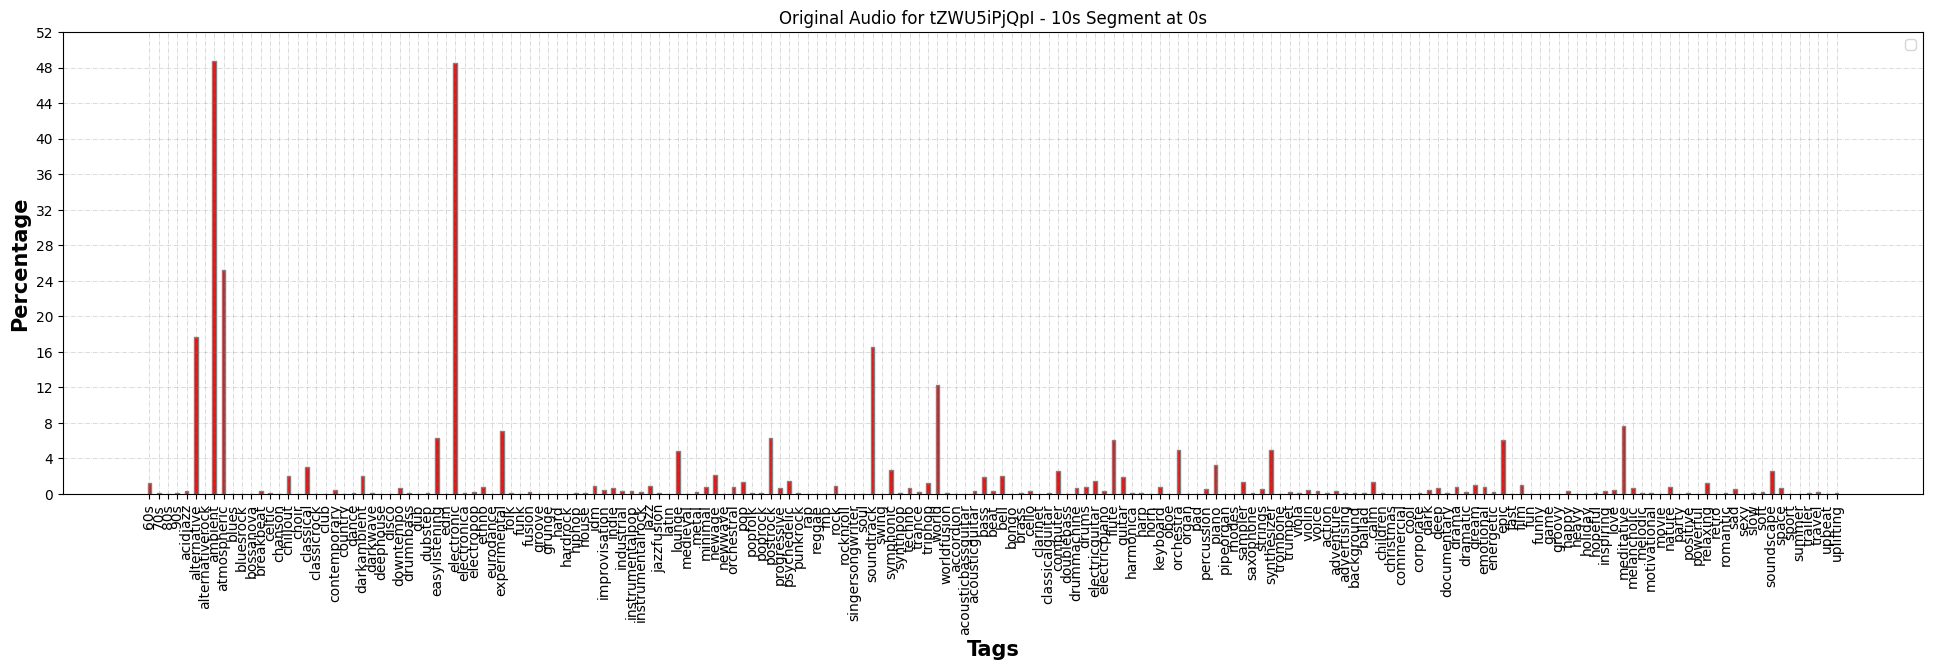

In [7]:
plot_for_bardo('cotw', 'bardo_3', 'tZWU5iPjQpI', 0, get_generated=False)

## Bardo 0 

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
[aist#0:0/pcm_s16le @ 0x56502bf15540] Guessed Channel Layout: mono
Input #0, wav, from '/home/felipe/Documents/Github/Pt-Brdo/experiments/cotw/results/bardo_0/audios/generated/bardo_0_EuLjzuOF5Nc.wav':
  Metadata:
    encoder         : Lavf58.76.100
  Duration: 00:29:59.00, bitrate: 512 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 32000 Hz, mono, s16, 512 kb/s
Stream mapping:
 

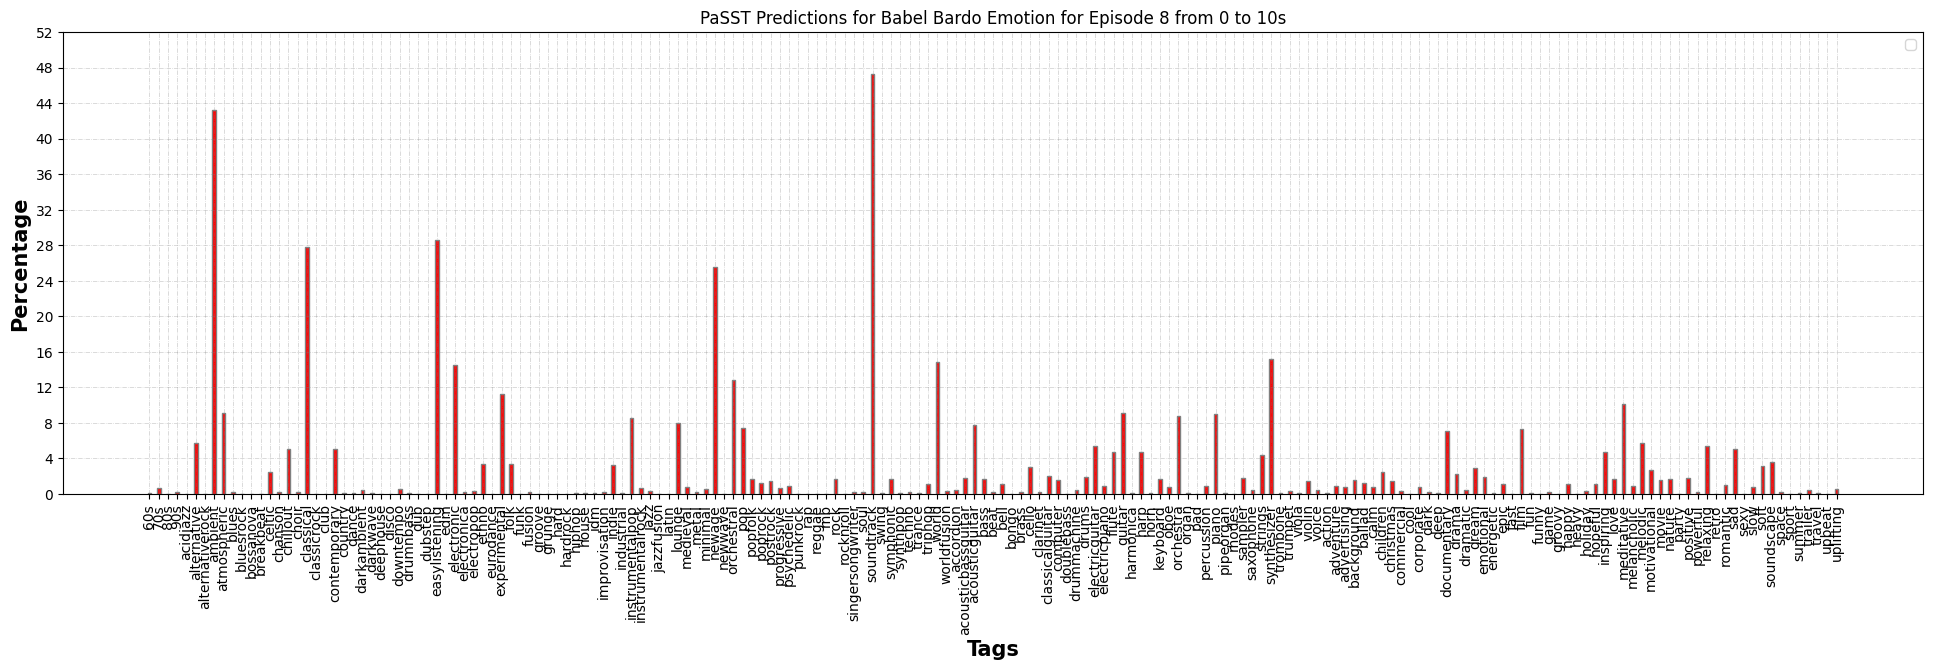

In [11]:
plot_for_bardo('cotw', 'bardo_0', 'EuLjzuOF5Nc', 0, get_original=False)

## Bardo 3

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
[aist#0:0/pcm_s16le @ 0x5646fc46c540] Guessed Channel Layout: mono
Input #0, wav, from '/home/felipe/Documents/Github/Pt-Brdo/experiments/cotw/results/bardo_3/audios/generated/bardo_3_tZWU5iPjQpI.wav':
  Metadata:
    encoder         : Lavf58.76.100
  Duration: 00:29:59.00, bitrate: 512 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 32000 Hz, mono, s16, 512 kb/s
Stream mapping:
 

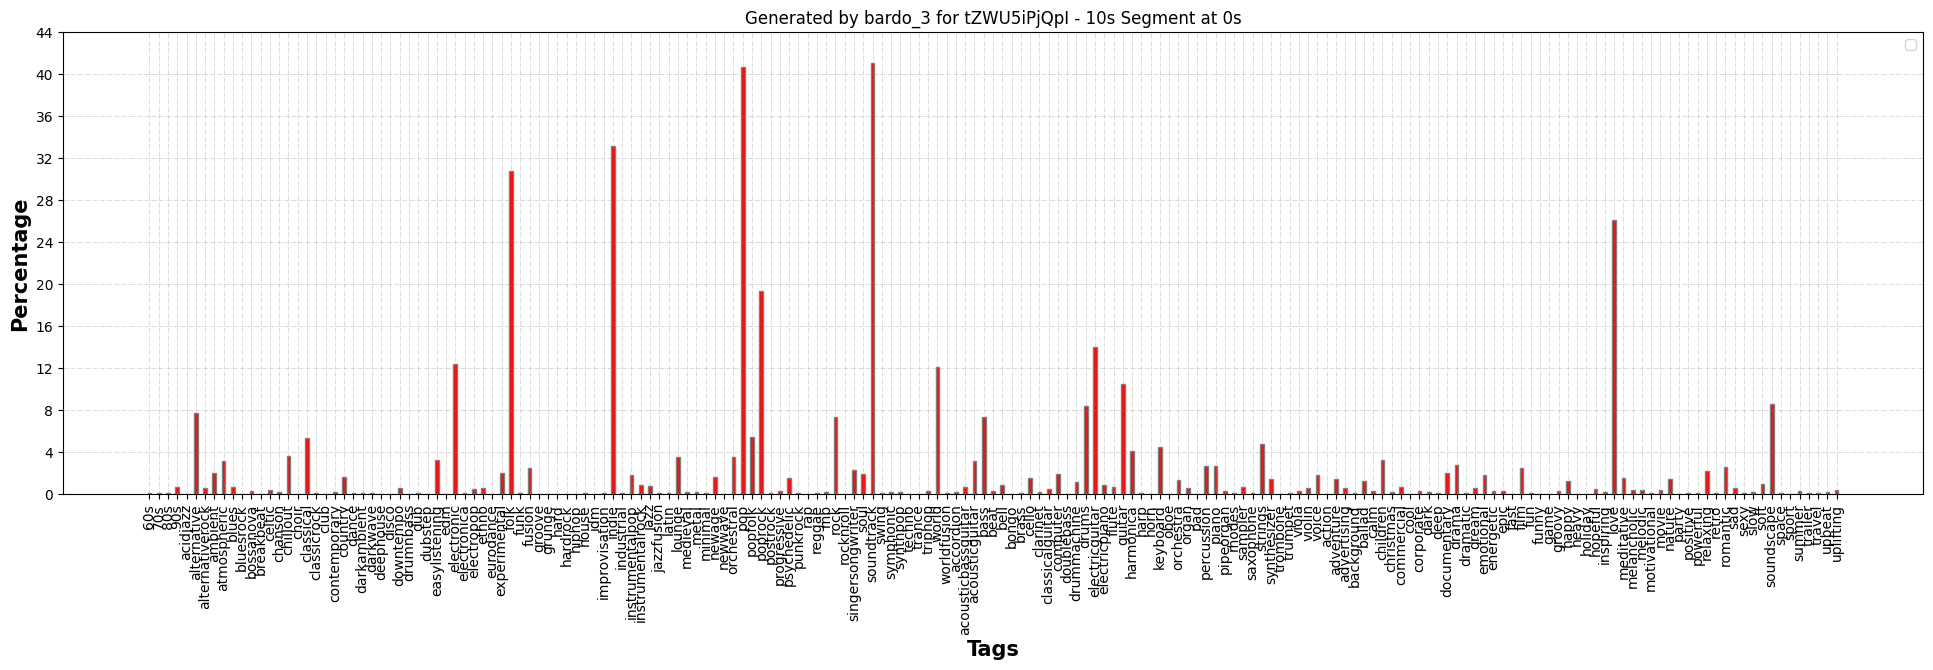

In [9]:
plot_for_bardo('cotw', 'bardo_3', 'tZWU5iPjQpI', 0, get_original=False)